In [1]:
# !pip install cpi
import cpi
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest

# cpi.update()

In [2]:
# compute CPI inflated prices for a df column
def inflate_column(data, price_column, year_column):
    """
    Adjust for inflation the series of values in column of the   
    dataframe data
    """
    return data.apply(lambda x: cpi.inflate(x[price_column], 
                      x[year_column]), axis=1)

In [39]:
# Read in prepared data with Bechdel test ratigns and budget
df = pd.read_csv('bechdel-budget.csv')

In [20]:
# Data preparation: skip if loading the cleaned data from CSV

# Merge datasets by imdb ID
df1 = pd.read_csv('movies-bechdel.csv')
df2 = pd.read_csv('movies-tmdb.csv') 

df2['imdbid'] = df2['IMDB_ID'].str[2:]
df2 = df2[df2['imdbid'].notna()]
df2['imdbid'] = df2['imdbid'].astype('int')

df = pd.merge(df1, df2, on='imdbid',how='left') 

# keep only the relevant columns
df_merged = df[['title','imdbid','year','rating','BUDGET']]

# keep only movies from 2003-2022
df = df_merged[df_merged['year'] >= 2003] 
df = df[df['year'] <= 2022]

# remove rows with missing and incorrect budget
df = df[df['BUDGET'].notna()]
df = df[df['BUDGET'] > 1000]

df['passed'] = df['rating'] ==3

# calculate CPI-inflated budgets
df['adj_budget'] = inflate_column(df, 'BUDGET','year')
df.describe()

# Save to CSV
# df.to_csv('bechdel-budget.csv', sep=',', index=False, encoding='utf-8')

In [19]:
# Total sample size
df.shape[0]

2722

In [40]:
# Create samples for RQ1
# 2003-2012
df_2003 = df[df['year'] < 2013]

# 2013-2022
df_2013 = df[df['year'] >= 2013]

print(df_2003.shape[0])
print(df_2013.shape[0])

1567
1155


In [41]:
# Total proportion passed
prop_total = sum(df['passed'] == True)/df.shape[0]

# Proportion passed 2003-2012
prop_2003 = sum(df_2003['passed'] == True)/df_2003.shape[0]

# Proportion passed 2013-2022
prop_2013 = sum(df_2013['passed'] == True)/df_2013.shape[0]

print(f"Total proportion passed: {prop_total}")
print(f"Proportion passed 2003-2012: {prop_2003}")
print(f"Proportion passed 2013-2022: {prop_2013}")

Total proportion passed: 0.5815576781778105
Proportion passed 2003-2012: 0.5603063178047224
Proportion passed 2013-2022: 0.6103896103896104


year
2003    0.570093
2004    0.609375
2005    0.571429
2006    0.572368
2007    0.582192
2008    0.522581
2009    0.502732
2010    0.586022
2011    0.533981
2012    0.579268
2013    0.597990
2014    0.556701
2015    0.561728
2016    0.617021
2017    0.642336
2018    0.649573
2019    0.677966
2020    0.733333
2021    0.600000
2022    0.400000
Name: True, dtype: float64


Text(0.5, 0, 'Year')

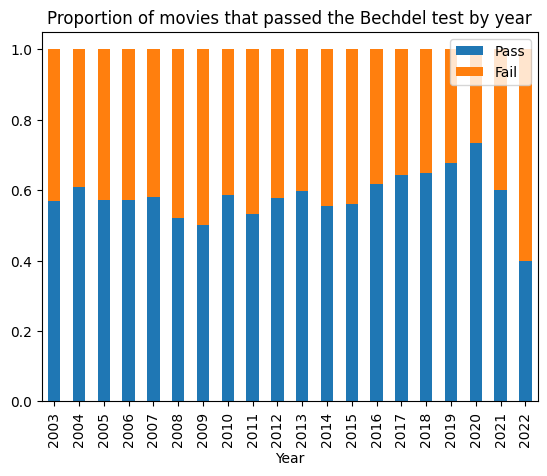

In [33]:
# create pivot table with counts by year
df_year_passed = pd.pivot_table(df, values='imdbid', index='year', columns='passed', aggfunc="count") # count the number of pets for each sex

# count total number per year to calculate proportion
year_counts = df['year'].value_counts()

# convert from counts to percentage for each year
for year in df['year'].unique():
  count = year_counts[year]
  df_year_passed.loc[year,:] = df_year_passed.loc[year,:]/count

print(df_year_passed[True])

# plot
df_year_passed = df_year_passed.sort_index(ascending = False,axis = 1)
df_year_passed.plot(kind='bar', stacked=True, title='Proportion of movies that passed the Bechdel test by year')
plt.legend(["Pass", "Fail"])
plt.xlabel('Year')

In [36]:
# run two-sample proportion z-test (one-tailed) for RQ1 

counts = [sum(df_2003['passed'] == True), sum(df_2013['passed'] == True)]
nobs = [df_2003.shape[0],df_2013.shape[0]]
_, pval = proportions_ztest(counts, nobs, alternative='smaller')
print(pval)

0.004423085474125463


In [38]:
# create samples for RQ2
# pass
df_pass = df[df['passed'] == True] 

# fail
df_fail = df[df['passed'] == False] 

print(df_pass.describe())
print(df_fail.describe())


             imdbid         year  rating        BUDGET    adj_budget
count  1.583000e+03  1583.000000  1583.0  1.583000e+03  1.583000e+03
mean   2.004437e+06  2011.458623     3.0  4.073222e+07  5.283637e+07
std    1.874462e+06     4.720309     0.0  5.247040e+07  6.653535e+07
min    1.211640e+05  2003.000000     3.0  1.500000e+04  2.117190e+04
25%    4.850790e+05  2008.000000     3.0  8.000000e+06  1.040833e+07
50%    1.441951e+06  2012.000000     3.0  2.000000e+07  2.703878e+07
75%    2.508094e+06  2015.000000     3.0  5.000000e+07  6.362065e+07
max    1.145605e+07  2022.000000     3.0  3.870000e+08  4.234381e+08
             imdbid         year       rating        BUDGET    adj_budget
count  1.139000e+03  1139.000000  1139.000000  1.139000e+03  1.139000e+03
mean   1.737945e+06  2011.011414     1.068481  4.925676e+07  6.511602e+07
std    1.675766e+06     4.473791     0.637616  5.299236e+07  6.969532e+07
min    1.024110e+05  2003.000000     0.000000  7.000000e+03  1.084481e+04
25%    4.

Text(0.5, 0, 'Adjusted budget (2022 dollars)')

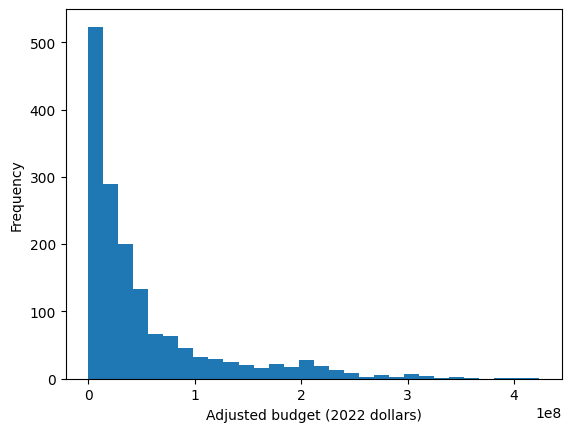

In [21]:
# Distribution plots
df_pass['adj_budget'].plot(kind='hist',bins=30)
plt.xlabel('Adjusted budget (2022 dollars)')

Text(0.5, 0, 'Adjusted budget (2022 dollars)')

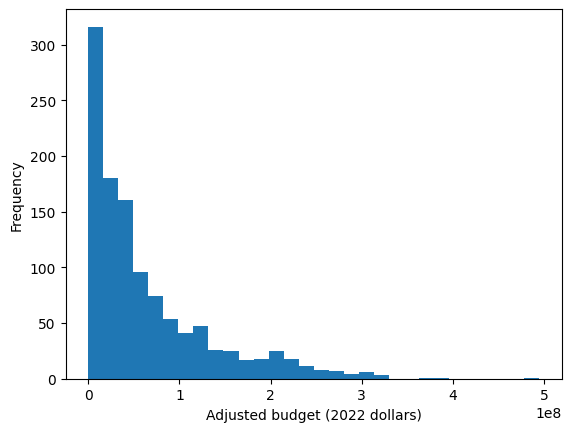

In [22]:
df_fail['adj_budget'].plot(kind='hist',bins=30)
plt.xlabel('Adjusted budget (2022 dollars)')


In [10]:
# run two-sample  z-test (one-tailed) for RQ2
_, p = ztest(df_pass['adj_budget'], x2=df_fail['adj_budget'], alternative='smaller')
print(p)

1.61043565462534e-06


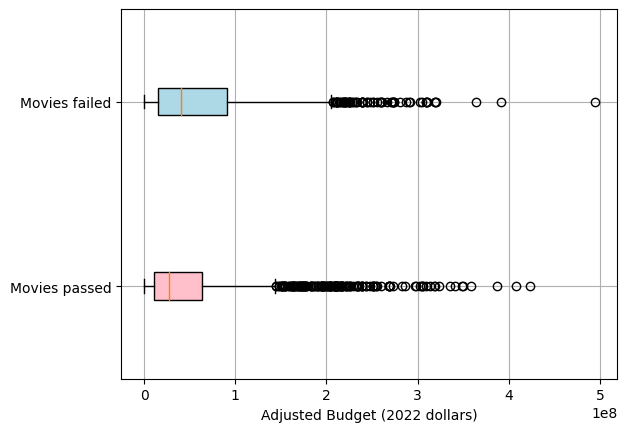

In [28]:
# plot boxplot
bplot = plt.boxplot([df_pass['adj_budget'],df_fail['adj_budget']], vert = False,patch_artist=True, labels = ['Movies passed','Movies failed'])
colors = ['pink', 'lightblue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.grid(visible=True)
plt.xlabel('Adjusted Budget (2022 dollars)')
plt.show()
